# Classify the topics with traditional NLP and ML techniques

In [1]:
# Connect google drive into google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Environment Setup

In [2]:
!pip install scikit-learn
!pip install xgboost
!pip install pandas
!pip install Unidecode 
!pip install matplotlib
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import unidecode # ASCII translation of Unicode text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer # 去除字根字尾
import re
import matplotlib.pyplot as plt

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression # model 1
from sklearn.naive_bayes import MultinomialNB # model 2
from sklearn.svm import SVC # model 3 --> Support Vector Machine for classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import classification_report, f1_score

%matplotlib inline

## Data Operation (Load the data)

In [5]:
train_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/test.csv')

In [6]:
train_df.head(5)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [7]:
test_df.head(5)

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [8]:
print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape)

Train shape:  (20972, 9)
Test shape:  (8989, 3)


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


## Data Operation (Check label distribution)

In [11]:
# Total number of different label
print('Computer Science: ', train_df['Computer Science'].sum())
print('Physics: ', train_df['Physics'].sum())
print('Mathematics: ', train_df['Mathematics'].sum())
print('Statistics: ', train_df['Statistics'].sum())
print('Quantative Biology: ', train_df['Quantitative Biology'].sum())
print('Quantative Finance: ', train_df['Quantitative Finance'].sum())

Computer Science:  8594
Physics:  6013
Mathematics:  5618
Statistics:  5206
Quantative Biology:  587
Quantative Finance:  249


In [12]:
# Percentage distribution of different label
print('Computer Science: ', round(train_df['Computer Science'].sum() / train_df.shape[0]*100))
print('Physics: ', round(train_df['Physics'].sum() / train_df.shape[0]*100))
print('Mathematics: ', round(train_df['Mathematics'].sum() / train_df.shape[0]*100))
print('Statistics: ', round(train_df['Statistics'].sum() / train_df.shape[0]*100))
print('Quantative Biology: ', round(train_df['Quantitative Biology'].sum() / train_df.shape[0]*100))

Computer Science:  41
Physics:  29
Mathematics:  27
Statistics:  25
Quantative Biology:  3


## Data Operation (Getting the length of text & obtain the title only)

In [13]:
train_df['TITLE_len'] = train_df['TITLE'].apply(len)
test_df['TITLE_len'] = test_df['TITLE'].apply(len)

<ipython-input-15-e7892345b72e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['TITLE_len'])


<Axes: xlabel='TITLE_len', ylabel='Density'>

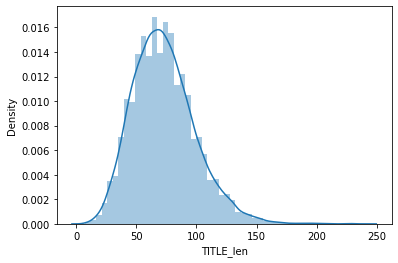

In [15]:
# normal distribution
sns.distplot(train_df['TITLE_len'])

<ipython-input-16-2a54e46525d1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_df['TITLE_len'])


<Axes: xlabel='TITLE_len', ylabel='Density'>

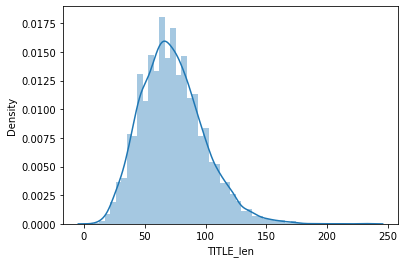

In [16]:
sns.distplot(test_df['TITLE_len'])

## Text preprocessing (Removing accented chars)

In [20]:
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

## Text preprocessing (Convert to lowercase)

In [21]:
def lower_(text):
    return text.lower()

## Text preprocessing (Tokenization & Remove stop words)

In [27]:
# need to download the stopwords before using the following functions
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
def filter_sentence(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = []

    for w in word_tokens:
      if not w in stop_words:
        filtered_sentence.append(w)
    
    return (' '.join(filtered_sentence))

In [29]:
# testing with the above function
print(filter_sentence('I am a boy'))

I boy


## Remove the stemmer of each char

In [31]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
  stemmed_sentence = ""
  for word in sentence.split():
    stem = stemmer.stem(word)
    stemmed_sentence += stem
    stemmed_sentence += " "
  stemmed_sentence = stemmed_sentence.strip()
  return stemmed_sentence

## remove special characters with regex

In [33]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

## Apply and save the change after pre-processing

In [37]:
train_df['TITLE'] = train_df['TITLE'].apply(remove_accented_chars)
test_df['TITLE'] = test_df['TITLE'].apply(remove_accented_chars)

train_df['TITLE'] = train_df['TITLE'].apply(lower_)
test_df['TITLE'] = test_df['TITLE'].apply(lower_)

train_df['TITLE'] = train_df['TITLE'].apply(remove_special_characters)
test_df['TITLE'] = test_df['TITLE'].apply(remove_special_characters)

train_df['TITLE'] = train_df['TITLE'].apply(filter_sentence)
test_df['TITLE'] = test_df['TITLE'].apply(filter_sentence)

train_df['TITLE'] = train_df['TITLE'].apply(stemming)
test_df['TITLE'] = test_df['TITLE'].apply(stemming)

In [39]:
train_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/new_train.csv', encoding='utf8', index=0)
test_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/new_test.csv', encoding='utf8', index=0)

## Training with preprocessed dataset

In [4]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/new_train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/new_test.csv')

In [5]:
train.describe()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,10486.500000,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873,72.897721
std,6054.239259,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317,26.128903
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,5243.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000
50%,10486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.000000
75%,15729.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,88.000000
max,20972.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,239.000000


In [6]:
train.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len
0,1,reconstruct subjectspecif effect map,Predictive models allow subject-specific inf...,1,0,0,0,0,0,43
1,2,rotat invari neural network,Rotation invariance and translation invarian...,1,0,0,0,0,0,34


In [7]:
test.describe()

,ID,TITLE_len
count,8989.000000,8989.000000
mean,25467.000000,72.938147
std,2595.045118,26.060040
min,20973.000000,8.000000
25%,23220.000000,54.000000
50%,25467.000000,71.000000
75%,27714.000000,88.000000
max,29961.000000,233.000000


In [8]:
test.head(2)

,ID,TITLE,ABSTRACT,TITLE_len
0,20973,closedform margin likelihood gammapoisson matr...,We present novel understandings of the Gamma...,69
1,20974,laboratori midir spectra equilibr igneous mete...,Meteorites contain minerals from Solar Syste...,114


## Correlation analysis with training dataset

<Axes: >

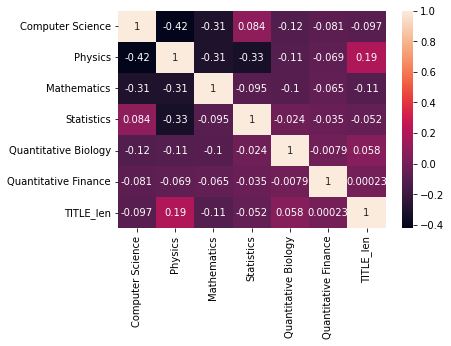

In [9]:
# Correlation analysis
sns.heatmap(train.drop(['ID'], axis=1).corr(), annot=True)

## Split the training and testing dataset

In [10]:
training_dataset, testing_dataset = train_test_split(train, random_state=101, test_size=0.3, shuffle=True)

In [11]:
training_dataset

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TITLE_len
16749,16750,full bayesian model handl structur one missing...,Economic evaluations from individual-level d...,0,0,0,1,0,0,114
6480,6481,stabil condit ttilt theori maxim green sequenc,Extending the notion of maximal green sequen...,0,0,1,0,0,0,68
7155,7156,applic multiband forc photometri one squar deg...,We apply The Tractor image modeling code to ...,0,1,0,0,0,0,144
14023,14024,noether number davenport constant group order ...,The computation of the Noether numbers of al...,0,0,1,0,0,0,83
2884,2885,25 tweet know new model predict person social ...,Predicting personality is essential for soci...,1,0,0,0,0,0,75
...,...,...,...,...,...,...,...,...,...,...
5695,5696,symbol comput framework constitut model base e...,The entropy principle in the formulation of ...,0,1,0,0,0,0,87
8006,8007,lazi automata techniqu ws1s,We present a new decision procedure for the ...,1,0,0,0,0,0,33
17745,17746,symbol invari partit construct,The symbol is used to describe the Springer ...,0,0,1,0,0,0,50
17931,17932,galaxi veil excit hydrogen,Many of the baryons in our Galaxy probably l...,0,1,0,0,0,0,37


## Using TF-IDF to train the model

In [12]:
# Define the vectorizer of TF
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting the vectorizer to training and testing set
tfv.fit(list(train['TITLE'].values) + list(test['TITLE'].values))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [13]:
#Train
xtrain_tfv = tfv.transform(training_dataset['TITLE']) 
xvalid_tfv = tfv.transform(testing_dataset['TITLE'])

#Test
xtest_tfv = tfv.transform(test['TITLE'])

In [14]:
# Define the vectorizer of IDF
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(train['TITLE'].values) + list(test['TITLE'].values))

CountVectorizer(ngram_range=(1, 3), stop_words='english',
                token_pattern='\\w{1,}')

In [15]:
#Train
xtrain_ctv = ctv.transform(training_dataset['TITLE']) 
xvalid_ctv = ctv.transform(testing_dataset['TITLE'])

#Test
xtest_ctv = ctv.transform(test['TITLE'])

In [16]:
# Apply SVD
# the number of n_components is not fixed, can be changed
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)
xtest_svd_scl = scl.transform(xtest_svd)

In [17]:
#targets that need to be predicted
targets=['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']

# DataFrame for saving the predictions
ev_pred=pd.DataFrame()
test_pred=pd.DataFrame()

## Logistic Regression

In [19]:
#Using LogisticRegression one at a time on tf_idf
for t in targets:

    y_train=training_dataset[t]
    y_test=testing_dataset[t]

    #using LogisticRegression
    classifier = LogisticRegression()
    classifier.fit(xtrain_tfv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_tfv)
    test_pred[t] = classifier.predict(xtest_tfv)

# Print the testing result of each category
for t in targets:
    print(t)
    print(f1_score(testing_dataset[t],ev_pred[t]))

Computer Science
0.7545473124872266
Physics
0.7866538338145653
Mathematics
0.696927374301676
Statistics
0.6414083429008802
Quantitative Biology
0.0
Quantitative Finance
0.02777777777777778


In [20]:
output = pd.DataFrame({'ID': test['ID'], 'Computer Science':test_pred['Computer Science'],'Physics':test_pred['Physics'],'Mathematics':test_pred['Mathematics'],'Statistics':test_pred['Statistics'],'Quantitative Biology':test_pred['Quantitative Biology'],'Quantitative Finance':test_pred['Quantitative Finance'] })
output.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Multi_Label_TextClassification/Outputs/tfIDF_LR.csv', index=False)

In [22]:
#Using LogisticRegression one at a time on ctv
for t in targets:

    y_train=training_dataset[t]
    y_test=testing_dataset[t]

    #using LogisticRegression
    classifier = LogisticRegression(max_iter=10000)
    classifier.fit(xtrain_ctv, y_train)
    
    ev_pred[t] = classifier.predict(xvalid_ctv)
    test_pred[t] = classifier.predict(xtest_ctv)

for t in targets:
    print(t)
    print(f1_score(testing_dataset[t],ev_pred[t]))

Computer Science
0.7595343235648334
Physics
0.7890025575447571
Mathematics
0.7089279787587122
Statistics
0.6671485363209252
Quantitative Biology
0.09195402298850576
Quantitative Finance
0.07792207792207792
